In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, BatchSampler, RandomSampler, random_split

from datetime import date

from data.torch_dataset import SingleChordDataset, collate_fn_single_chord
from algorithm.multi_pitch_detection_fourier import get_cisoid_dict

from hyperparameters import TEMPLATE_PATH
%matplotlib inline

In [2]:
pitch_repeat = 1
hdf5s_dir = os.path.join("data", "synth_chopped", "2004_h5")
template_hdf5s_dir = os.path.join("data", "synth_chopped", "note_templates")
single_chord_dataset = SingleChordDataset(hdf5s_dir, pitch_repeat = pitch_repeat, random_len = True, fix_len =True, insert_spectrum = False)

1600


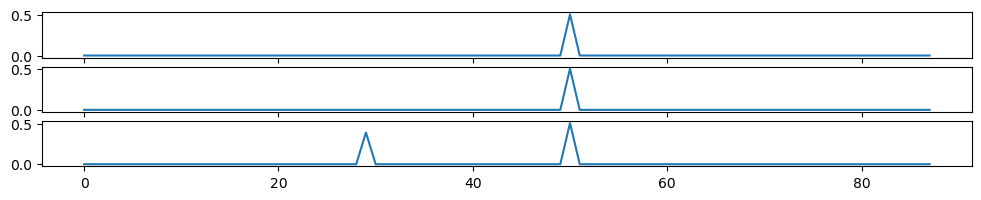

In [3]:
from data.data_utils import play_audio
i_display = 100
audio_to_display = single_chord_dataset[i_display]["audio"]
print(len(audio_to_display))
play_audio(np.concatenate([audio_to_display]), sample_rate = 16000)
if "spectrum" in single_chord_dataset[i_display]:
    fig, ax = plt.subplots(4,1, figsize=(12,3))
    ax[0].plot(single_chord_dataset[i_display]["velocity_roll"])
    ax[1].plot(single_chord_dataset[i_display]["velocity_roll_repeat"])
    ax[2].plot(single_chord_dataset[i_display]["prevchord"])
    ax[3].plot(single_chord_dataset[i_display]["spectrum"])
else:
    fig, ax = plt.subplots(3,1, figsize=(12,2))
    ax[0].plot(single_chord_dataset[i_display]["velocity_roll"])
    ax[1].plot(single_chord_dataset[i_display]["velocity_roll_repeat"])
    ax[2].plot(single_chord_dataset[i_display]["prevchord"])

In [4]:
batch_size = 160

train_val_test_split = [0.8,0.1,0.1]
train_val_test_split[0] = int(train_val_test_split[0]*len(single_chord_dataset))
train_val_test_split[1] = int(train_val_test_split[1]*len(single_chord_dataset))
train_val_test_split[2] = int(len(single_chord_dataset) - train_val_test_split[0] - train_val_test_split[1])

single_chord_train_set, single_chord_val_set, single_chord_test_set = random_split(
    single_chord_dataset, train_val_test_split
)
train_sampler = BatchSampler(RandomSampler(single_chord_train_set), batch_size=batch_size, drop_last=True)
val_sampler = BatchSampler(RandomSampler(single_chord_val_set), batch_size=1, drop_last=True)

single_chord_train_loader = DataLoader(dataset=single_chord_train_set, 
    batch_sampler=train_sampler, collate_fn=collate_fn_single_chord, pin_memory=True
)
single_chord_val_loader = DataLoader(dataset=single_chord_val_set, 
    batch_sampler=val_sampler, collate_fn=collate_fn_single_chord, pin_memory=True
)

In [5]:
from data.data_utils import velocity2amp
from algorithm.multi_pitch_detection_fourier import remove_amp_vec_noise
from evaluate_main import calculate_single_chord_metric
from utils import save_checkpoint_np
from hyperparameters import PITCH_FREQUENCY_GRID, PITCH_FREQUENCY_GRID_FINER

training_config = {
    "checkpoint_dir": "checkpoints",
    "model_name": "PitchTemplateMatrix",
    "learning_rate": 0.05,
    "start_train_iter": 0,
    "max_train_iter": 500, # it is better to set it higher than 10000; this is only a debugging example
    "print_iter": 100,
    "save_checkpoint_iter": 500,
    "validate_iter": 20
}
def train_acoustic_template_map(training_config, acoustic_model, single_chord_train_loader, single_chord_validate_loader = None, plot_validate = False):
    print_iter = training_config["print_iter"]
    lambda_factor = 0.001
    val_times = 0
    for i_iter in range(training_config["start_train_iter"], training_config["max_train_iter"]):
        # save checkpoint
        if i_iter % training_config["save_checkpoint_iter"] == 0:
            with open('test.npy', 'wb') as f:
                np.save(f, np.array([1, 2]))
            save_checkpoint_np(acoustic_model.template_A, training_config["checkpoint_dir"], i_iter, 
                model_name = training_config["model_name"]
            )
        
        # validate
        if (single_chord_validate_loader is not None) and i_iter % print_iter == 0:
            y_val_list = []
            yhat_val_list = []
            yhat_post_val_list = []
            for _ in range(training_config["validate_iter"]):
                data_dict_val = next(iter(single_chord_validate_loader))
                x_val = np.squeeze(data_dict_val["audio"])
                yhat_val_list.append(acoustic_model.single_chord_transcription_powergram(x_val))
                yhat_post_val_list.append(remove_amp_vec_noise(yhat_val_list[-1], rel_amp_thres = 0.1, rel_amp_thres_octave = 0.4))
                y_val_list.append(np.squeeze(data_dict_val["velocity_roll"]))

            running_P, running_R, running_F1 = calculate_single_chord_metric(y_val_list, yhat_post_val_list)
            val_times += 1
            
            if plot_validate and i_iter % (print_iter) == 0:
                fig, ax = plt.subplots(1,1,figsize = (12,4))
                ax.plot(y_val_list[0])
                ax.plot(yhat_val_list[0])
                ax.set_title("validate result (velocity) at iter "+str(i_iter))
                ax.legend(["ground-truth", "estimated"])
        
        # training
        batch_data_dict = next(iter(single_chord_train_loader))
        
        batch_a = acoustic_model.apply_frame_analysis_operator_batch(batch_data_dict["audio"], spectrum = True)
        batch_y = batch_data_dict["velocity_roll_repeat"]
        batch_size, pitch_num = batch_y.shape
        
        cov = batch_y.T @ batch_y + lambda_factor * np.eye(pitch_num)
        debug = False
        if debug:
            fig, ax = plt.subplots(1,3,figsize = (12,4))
            ax[0].matshow(batch_y.T @ batch_y)
            ax[1].matshow(cov)
            ax[2].matshow(batch_a.T @ batch_y)
        grad = acoustic_model.template_A @ cov - batch_a.T @ batch_y
        
        acoustic_model.template_A = acoustic_model.template_A - training_config["learning_rate"] * grad
        acoustic_model.prepare_convex_problem()
        
        # print statistics
        if i_iter % print_iter == 0 and i_iter > 0:
            eval_P = running_P / val_times
            eval_R = running_R / val_times
            eval_F1 = running_F1 / val_times
            
            if single_chord_validate_loader is not None:
                print(f'[{i_iter:5d}]: validate P,R,F1: {eval_P:.4f},{eval_R:.4f},{eval_F1:.4f}')
            val_times = 0
    
    return acoustic_model

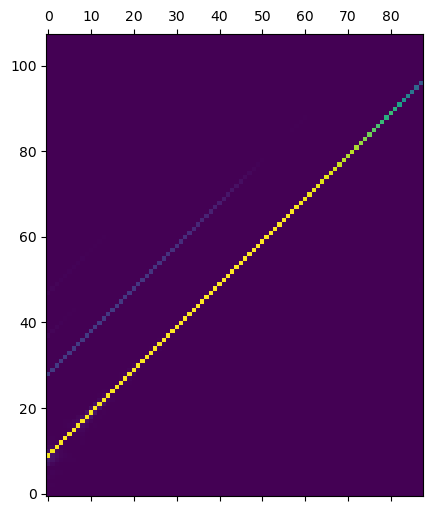

In [6]:
grid_under_use = PITCH_FREQUENCY_GRID

acoustic_model = get_cisoid_dict(TEMPLATE_PATH, frequency_grid = grid_under_use, pitch_repeat = pitch_repeat)
fig, ax = plt.subplots(1,1, figsize = (16,6))
ax.matshow(acoustic_model.template_A, origin="lower")

[  100]: validate P,R,F1: 0.1952,0.4100,0.2645
[  200]: validate P,R,F1: 0.3235,0.9362,0.4809
[  300]: validate P,R,F1: 0.3588,0.8704,0.5081
[  400]: validate P,R,F1: 0.5056,0.8824,0.6429


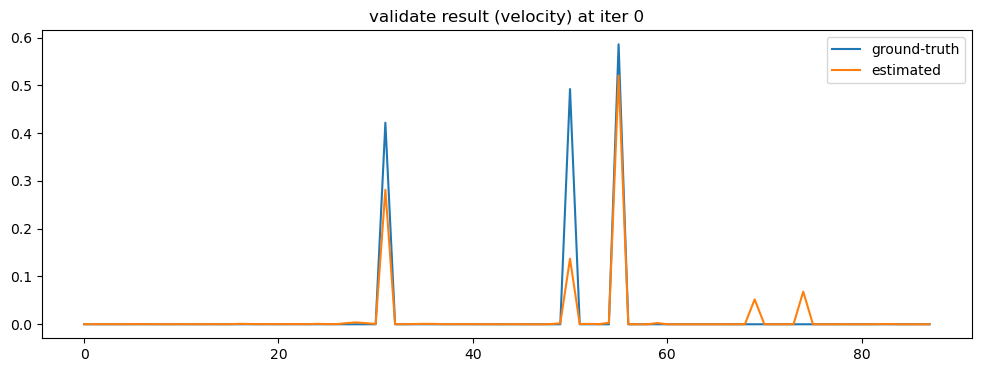

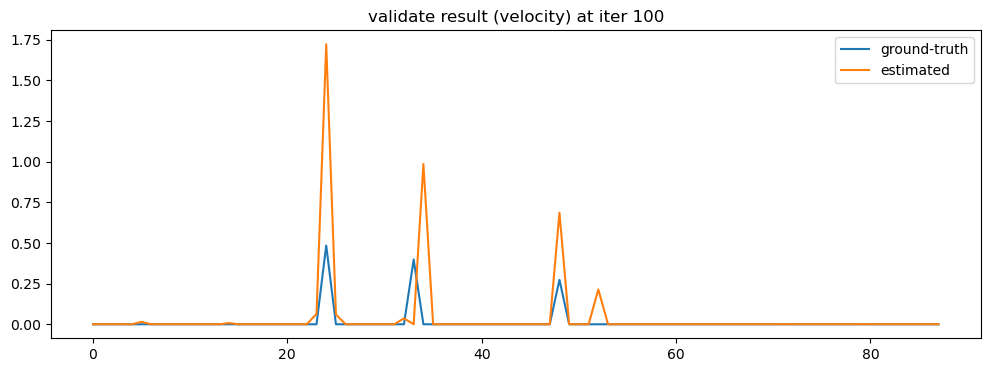

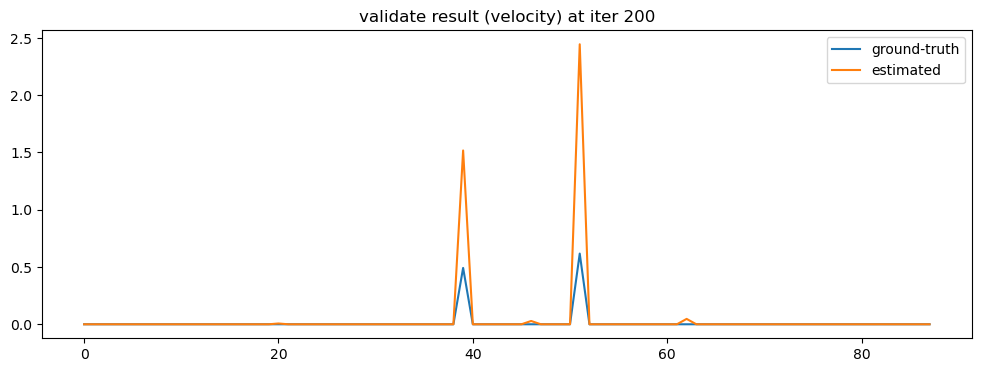

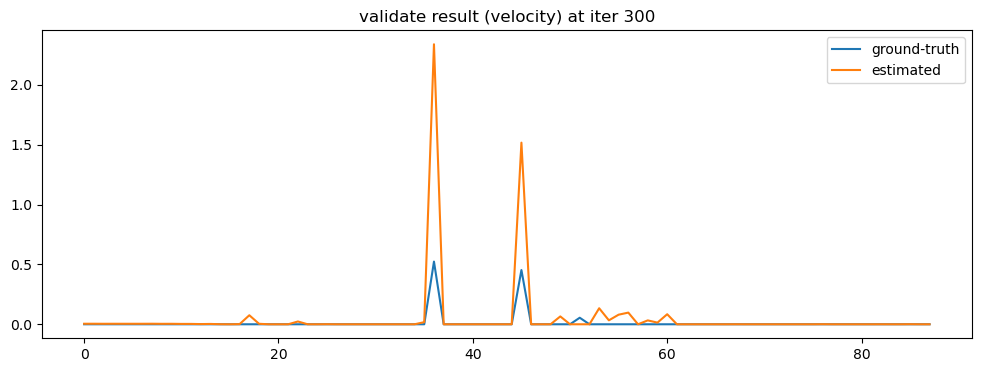

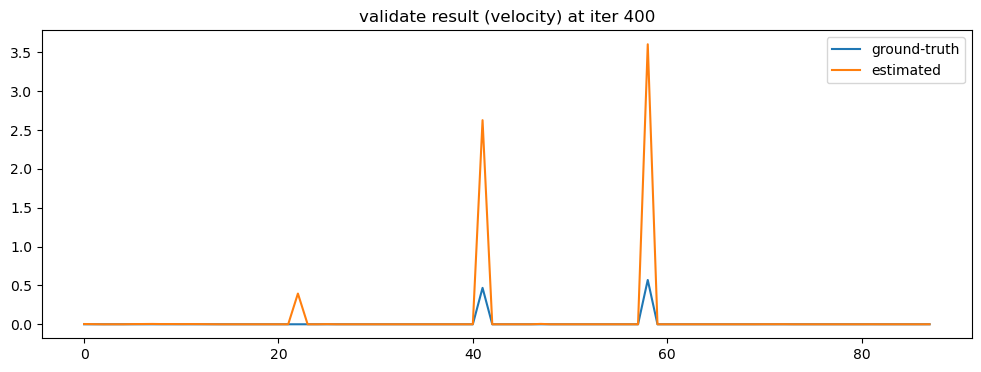

In [7]:
new_acoustic_model = train_acoustic_template_map(training_config, acoustic_model, 
    single_chord_train_loader, single_chord_validate_loader = single_chord_val_loader, 
    plot_validate = True
)

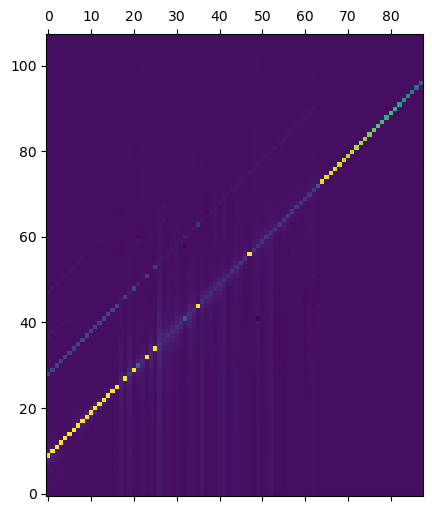

In [8]:
fig, ax = plt.subplots(1,1, figsize = (16,6))
ax.matshow(acoustic_model.template_A, origin="lower")